Instantiate the ResNet50 model

In [1]:
from keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Architecture of the InceptionV3 convolutional base

In [2]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Fast Feature Extraction without Data Augmentation

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(224, 224), batch_size=batch_size, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) 
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 960ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 976ms/step


The extracted features are currently of shape (samples, 7, 7, 2048). Feed them to a densely connected classifier, First flatten them (samples, 100352)

In [4]:
train_features = np.reshape(train_features, (2000, 7*7* 2048))
validation_features = np.reshape(validation_features, (1000, 7*7* 2048))
test_features = np.reshape(test_features, (1000, 7*7* 2048))

Define densely connected classifier (the use of dropout for regularization) and train it on the data and labels

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 21s 204ms/step - loss: 0.8348 - acc: 0.5190 - val_loss: 0.6549 - val_acc: 0.6130
Epoch 2/30
100/100 [==============================] - 20s 204ms/step - loss: 0.6844 - acc: 0.5760 - val_loss: 0.6417 - val_acc: 0.6310
Epoch 3/30
100/100 [==============================] - 20s 204ms/step - loss: 0.6742 - acc: 0.5935 - val_loss: 0.6613 - val_acc: 0.5780
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.6635 - acc: 0.6025 - val_loss: 0.6550 - val_acc: 0.5990
Epoch 5/30
100/100 [==============================] - 20s 201ms/step - loss: 0.6543 - acc: 0.6090 - val_loss: 0.6274 - val_acc: 0.6470
Epoch 6/30
100/100 [==============================] - 20s 200ms/step - loss: 0.6504 - acc: 0.6010 - val_loss: 0.6377 - val_acc: 0.6170
Epoch 7/30
100/100 [==============================] - 20s 202ms/step - loss: 0.6492 - acc: 0.6170 - val_loss: 0.6283 - val_acc: 0.6400
Epoch 8/30
100/100 [==============================] - 2

The loss and accuracy curves during training.

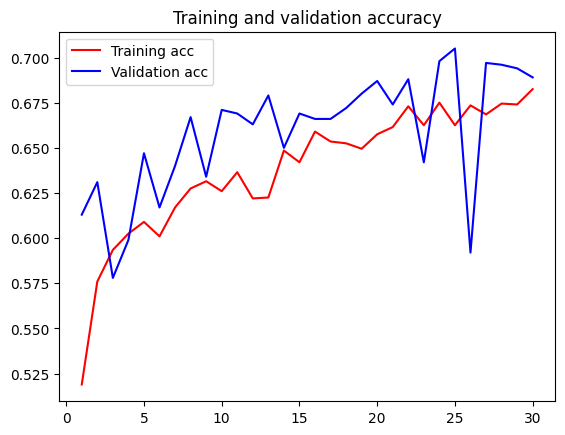

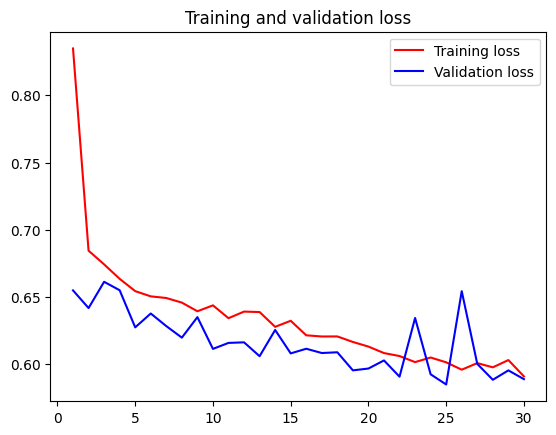

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Calculating Accuracy, Precision, Recall, and F1-score

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting on test data
test_predictions = model.predict(test_features)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Cat', 'Dog']))


32/32 [==============================] - 1s 18ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.62      0.80      0.70       500
         Dog       0.71      0.50      0.59       500

    accuracy                           0.65      1000
   macro avg       0.67      0.65      0.64      1000
weighted avg       0.67      0.65      0.64      1000



Generating the Confusion Matrix

Confusion Matrix:
[[399 101]
 [248 252]]


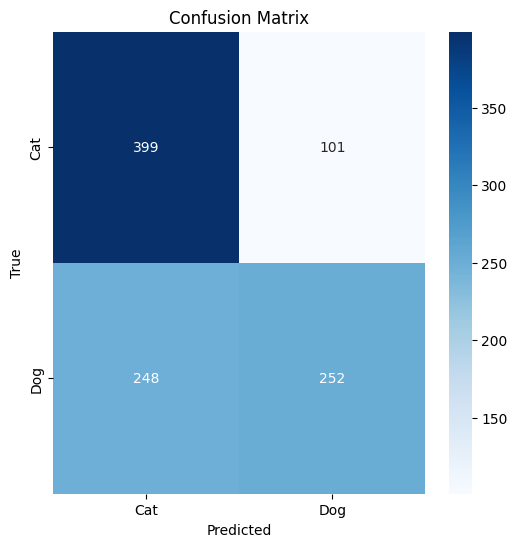

In [10]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Feature Extraction with Data Augmentation

In [1]:
from keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [2]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49278337 (187.98 MB)
Trainable params: 49225217 (187.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Freeze the convolutional base

In [4]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216
This is the number of trainable weights after freezing the conv base: 4


Start training model, with the data-augmentation configuration

In [5]:
import os
import numpy as np

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

In [8]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 174s 2s/step - loss: 0.8050 - acc: 0.5340 - val_loss: 0.8487 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 181s 2s/step - loss: 0.7484 - acc: 0.5500 - val_loss: 0.6975 - val_acc: 0.5410
Epoch 3/30
100/100 [==============================] - 179s 2s/step - loss: 0.7465 - acc: 0.5495 - val_loss: 0.8815 - val_acc: 0.5000
Epoch 4/30
100/100 [==============================] - 178s 2s/step - loss: 0.7555 - acc: 0.5550 - val_loss: 0.7445 - val_acc: 0.5120
Epoch 5/30
100/100 [==============================] - 177s 2s/step - loss: 0.7450 - acc: 0.5565 - val_loss: 0.6319 - val_acc: 0.6540
Epoch 6/30
100/100 [==============================] - 177s 2s/step - loss: 0.6988 - acc: 0.5950 - val_loss: 0.6278 - val_acc: 0.6480
Epoch 7/30
100/100 [==============================] - 178s 2s/step - loss: 0.7180 - acc: 0.5770 - val_loss: 0.6301 - val_acc: 0.6640
Epoch 8/30
100/100 [==============================] - 178s 2s/step - 

Plot the results

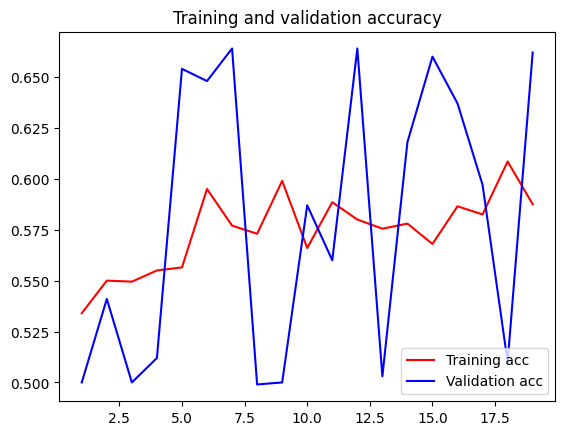

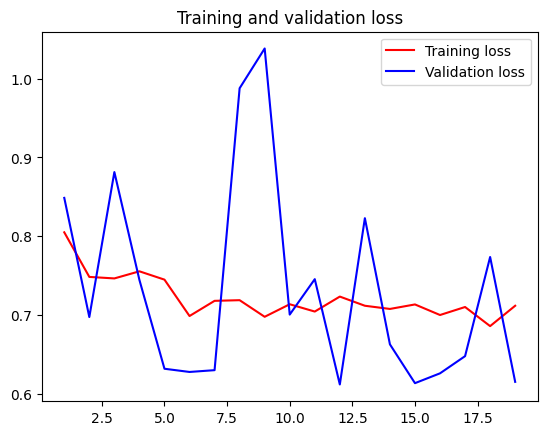

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Validation accuracy and loss are unbalance (sudden fluctuations) than the previous model.

Calculating Accuracy, Precision, Recall, and F1-score

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 47s 947ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.60      0.79      0.68       500
         Dog       0.69      0.47      0.56       500

    accuracy                           0.63      1000
   macro avg       0.64      0.63      0.62      1000
weighted avg       0.64      0.63      0.62      1000



Generating the Confusion Matrix

Confusion Matrix:
[[394 106]
 [264 236]]


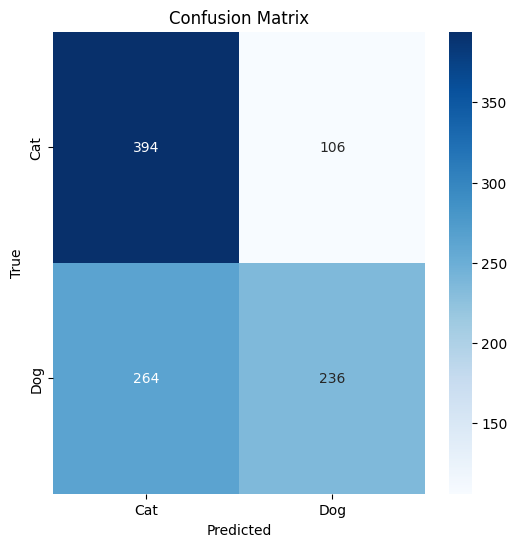

In [13]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning

In [1]:
from keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [2]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49278337 (187.98 MB)
Trainable params: 49225217 (187.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Fine-tune only the top two or three layers in the convolutional base

In [4]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Begin fine-tuning the network

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])


In [8]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 201s 2s/step - loss: 0.7439 - acc: 0.5505 - val_loss: 0.6982 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 205s 2s/step - loss: 0.7059 - acc: 0.5815 - val_loss: 0.6575 - val_acc: 0.6440
Epoch 3/30
100/100 [==============================] - 203s 2s/step - loss: 0.6844 - acc: 0.5955 - val_loss: 0.7349 - val_acc: 0.5050
Epoch 4/30
100/100 [==============================] - 208s 2s/step - loss: 0.6765 - acc: 0.6065 - val_loss: 0.6536 - val_acc: 0.6380
Epoch 5/30
100/100 [==============================] - 207s 2s/step - loss: 0.6662 - acc: 0.5990 - val_loss: 0.6487 - val_acc: 0.6220
Epoch 6/30
100/100 [==============================] - 205s 2s/step - loss: 0.6674 - acc: 0.6020 - val_loss: 0.6197 - val_acc: 0.6580
Epoch 7/30
100/100 [==============================] - 201s 2s/step - loss: 0.6541 - acc: 0.6085 - val_loss: 0.5997 - val_acc: 0.6820
Epoch 8/30
100/100 [==============================] - 207s 2s/step - 

Getting curves

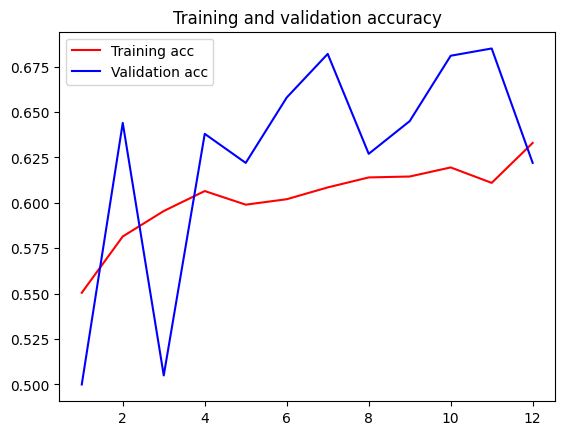

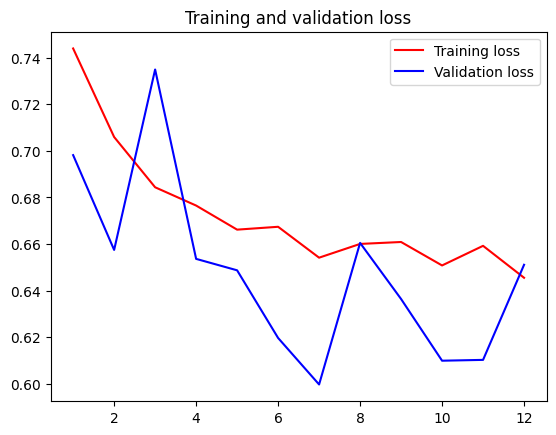

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Smoothing curves

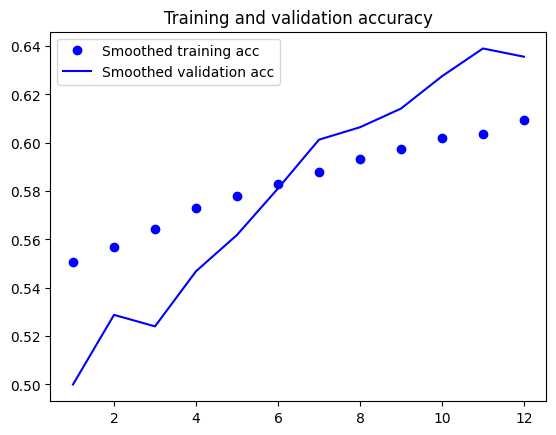

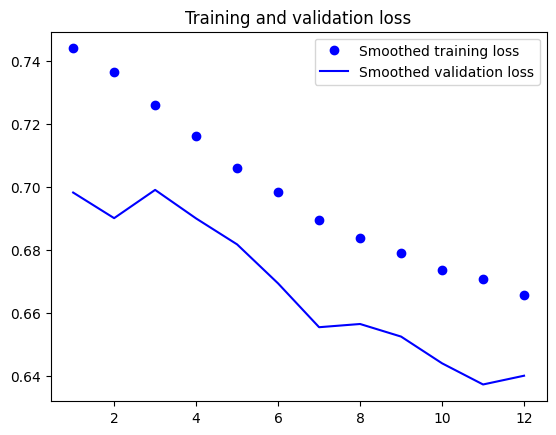

In [11]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

Evaluate this model on the test data

In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 55s 1s/step - loss: 0.6163 - acc: 0.6570
test acc: 0.6570000052452087


Calculating Accuracy, Precision, Recall, and F1-score

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 58s 1s/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.63      0.75      0.69       500
         Dog       0.69      0.56      0.62       500

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.65      1000
weighted avg       0.66      0.66      0.65      1000



Generating the Confusion Matrix

Confusion Matrix:
[[376 124]
 [219 281]]


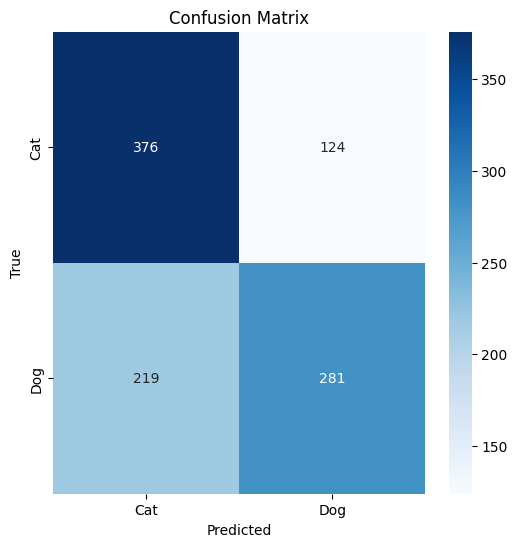

In [14]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning - 2

In [1]:
from keras.applications import InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26521889 (101.17 MB)
Trainable params: 26487457 (101.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [4]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv2d_85':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])


In [8]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 49s 460ms/step - loss: 0.3298 - acc: 0.8530 - val_loss: 0.1112 - val_acc: 0.9540
Epoch 2/30
100/100 [==============================] - 47s 467ms/step - loss: 0.2139 - acc: 0.9105 - val_loss: 0.1112 - val_acc: 0.9600
Epoch 3/30
100/100 [==============================] - 47s 468ms/step - loss: 0.1842 - acc: 0.9135 - val_loss: 0.1056 - val_acc: 0.9640
Epoch 4/30
100/100 [==============================] - 47s 470ms/step - loss: 0.1823 - acc: 0.9200 - val_loss: 0.1001 - val_acc: 0.9660
Epoch 5/30
100/100 [==============================] - 48s 482ms/step - loss: 0.1755 - acc: 0.9265 - val_loss: 0.0986 - val_acc: 0.9670
Epoch 6/30
100/100 [==============================] - 47s 465ms/step - loss: 0.1640 - acc: 0.9325 - val_loss: 0.0875 - val_acc: 0.9690
Epoch 7/30
100/100 [==============================] - 48s 478ms/step - loss: 0.1657 - acc: 0.9275 - val_loss: 0.0932 - val_acc: 0.9680
Epoch 8/30
100/100 [==============================] - 4

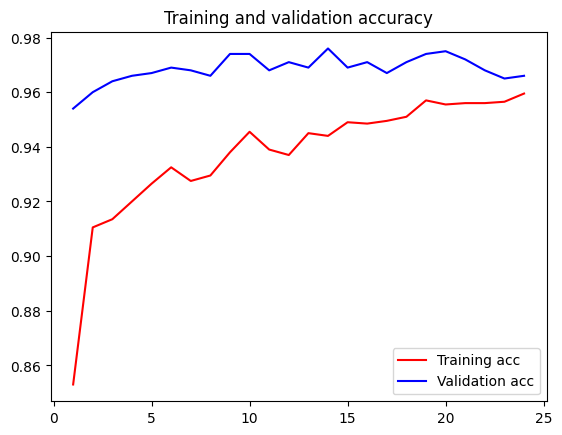

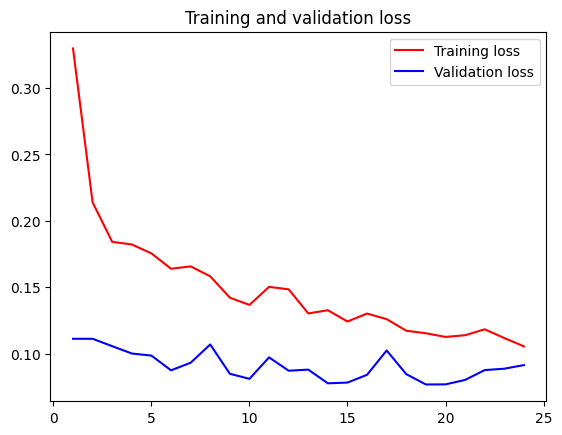

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

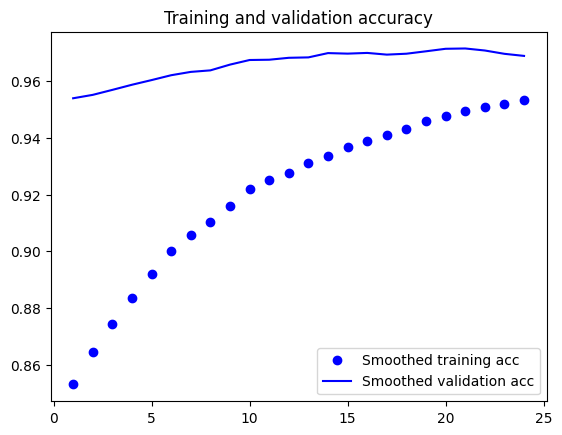

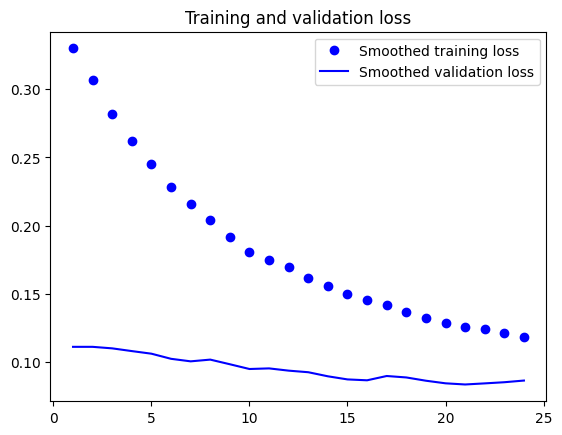

In [11]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 10s 209ms/step - loss: 0.1018 - acc: 0.9670
test acc: 0.9670000076293945


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 11s 210ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.98      0.97       500
         Dog       0.98      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Confusion Matrix:
[[488  12]
 [ 21 479]]


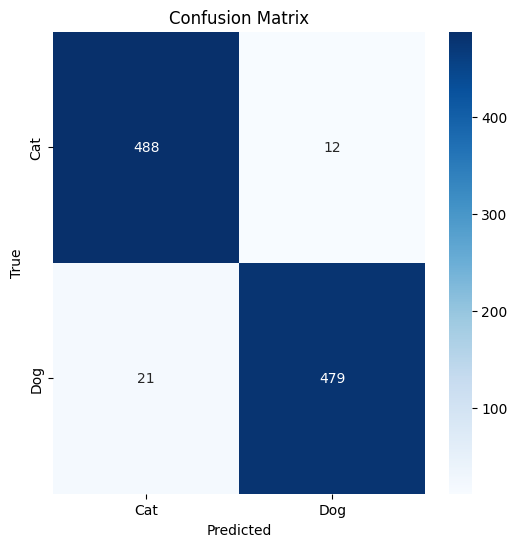

In [14]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning - 3

In [1]:
from keras.applications import InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [3]:
from keras import models, layers, optimizers, regularizers

# Model definition
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26521889 (101.17 MB)
Trainable params: 26487457 (101.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [5]:
# Unfreezing layers of the MobileNet model
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv2d_91':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [9]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [10]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 44s 405ms/step - loss: 0.9196 - acc: 0.7965 - val_loss: 0.6445 - val_acc: 0.9480
Epoch 2/30
100/100 [==============================] - 41s 408ms/step - loss: 0.7399 - acc: 0.8965 - val_loss: 0.6191 - val_acc: 0.9620
Epoch 3/30
100/100 [==============================] - 43s 431ms/step - loss: 0.7336 - acc: 0.9050 - val_loss: 0.6112 - val_acc: 0.9640
Epoch 4/30
100/100 [==============================] - 44s 437ms/step - loss: 0.7165 - acc: 0.9060 - val_loss: 0.6087 - val_acc: 0.9640
Epoch 5/30
100/100 [==============================] - 44s 438ms/step - loss: 0.7103 - acc: 0.9100 - val_loss: 0.5997 - val_acc: 0.9650
Epoch 6/30
100/100 [==============================] - 44s 438ms/step - loss: 0.6904 - acc: 0.9220 - val_loss: 0.5978 - val_acc: 0.9660
Epoch 7/30
100/100 [==============================] - 48s 481ms/step - loss: 0.6883 - acc: 0.9155 - val_loss: 0.5937 - val_acc: 0.9670
Epoch 8/30
100/100 [==============================] - 4

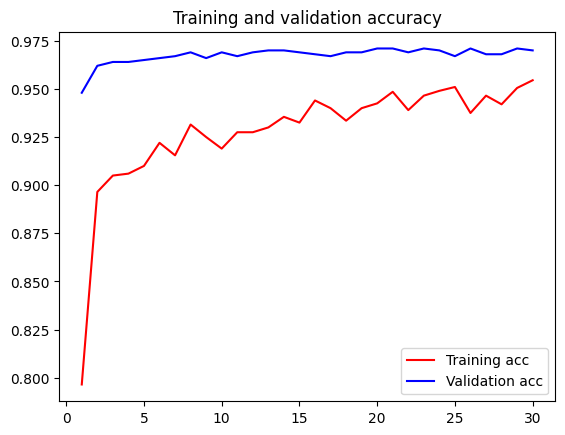

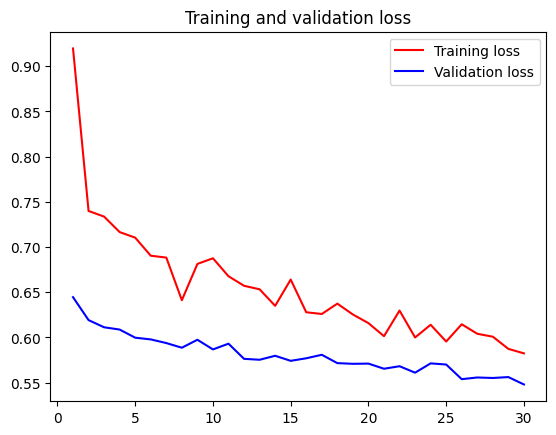

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

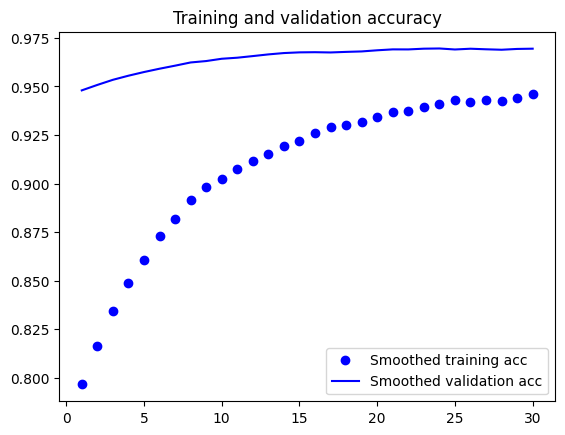

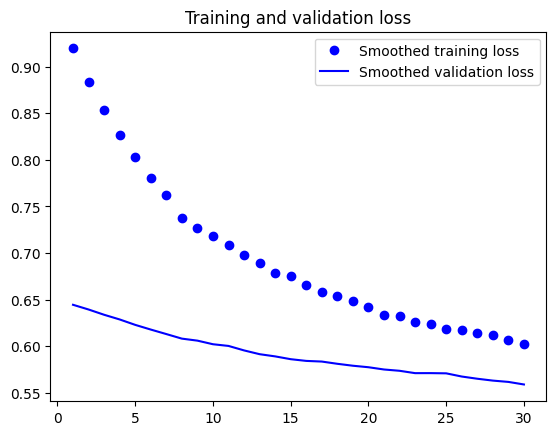

In [12]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

In [13]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 11s 212ms/step - loss: 0.5482 - acc: 0.9670
test acc: 0.9670000076293945


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 12s 219ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.97      0.97       500
         Dog       0.97      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Confusion Matrix:
[[485  15]
 [ 18 482]]


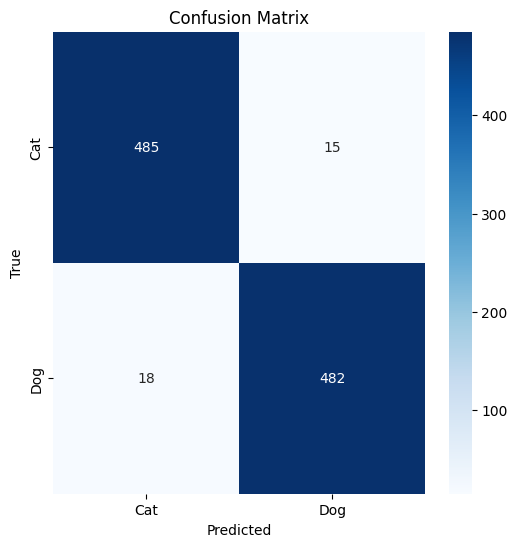

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


5 models from Inception V3 completed.